# Wilkinson Power Divider

In this notebook we create a [Wilkinson power divider](https://www.microwaves101.com/encyclopedias/wilkinson-power-splitters), which splits an input signal into two equals phase output signals. Theoritecal results about this circuit are exposed in reference [1]. Here we will reproduce the ideal circuit illustrated below and discussed in reference [2]. In this example, the circuit is designed to operate at 1 GHz.

![](wilkinson_power_divider.png)

 - [1] P. Hallbjörner, Microw. Opt. Technol. Lett. 38, 99 (2003).
 - [2] Microwaves 101: "Wilkinson Power Splitters" 

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import skrf as rf
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


In [3]:
# frequency band
freq = rf.Frequency(start=0, stop=2, npoints=501, unit='GHz')

# characteristic impedance of the ports
Z0_ports = 50

# resistor
R = 100
line_resistor = rf.media.DefinedGammaZ0(frequency=freq, Z0=R)
resistor = line_resistor.resistor(R, name='resistor')

# branches
Z0_branches = np.sqrt(2)*Z0_ports
beta = freq.w/rf.c
line_branches = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z0_branches, gamma=0+beta*1j)

d = line_branches.theta_2_d(90, deg=True)  # @ 90°(lambda/4)@ 1 GHz is ~ 75 mm
branch1 = line_branches.line(d, unit='m', name='branch1')
branch2 = line_branches.line(d, unit='m', name='branch2')

# ports
port1 = rf.Circuit.Port(freq, name='port1', z0=50)
port2 = rf.Circuit.Port(freq, name='port2', z0=50)
port3 = rf.Circuit.Port(freq, name='port3', z0=50)

# Connection setup
#┬Note that the order of appearance of the port in the setup is important 
connections = [
           [(port1, 0), (branch1, 0), (branch2, 0)],
           [(port2, 0), (branch1, 1), (resistor, 0)],
           [(port3, 0), (branch2, 1), (resistor, 1)]
        ]

# Building the circuit
C = rf.Circuit(connections)

The circuit setup can be checked by visualising the circuit graph (this requires the python package `networkx` to be available). 

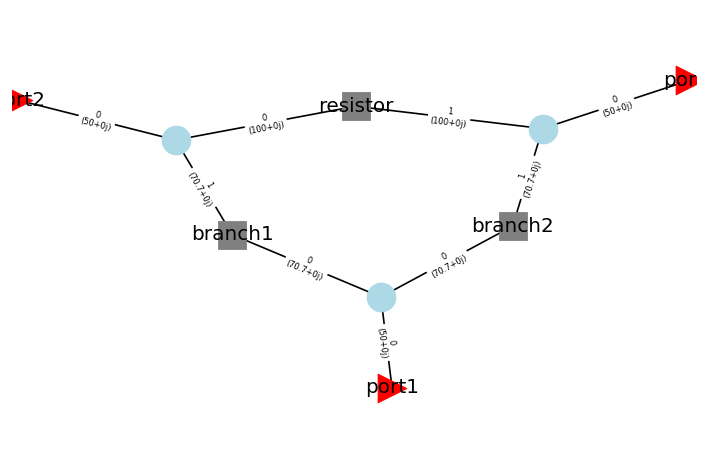

In [6]:
C.plot_graph(is_network_labels=True, is_edge_labels=True, is_port_labels=True, port_fontize=2)

Let's look to the scattering parameters of the circuit:

Text(0.5, 0.98, 'Ideal Wilkinson Divider @ 1 GHz')

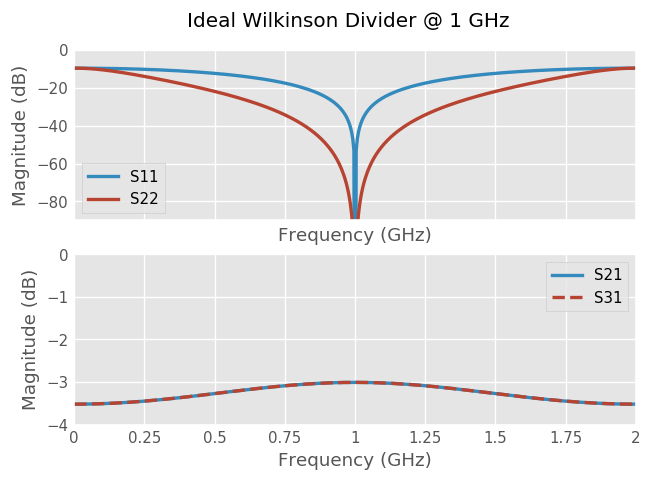

In [7]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
C.network.plot_s_db(ax=ax1, m=0, n=0,  lw=2)  # S11
C.network.plot_s_db(ax=ax1, m=1, n=1,  lw=2)  # S22
ax1.set_ylim(-90, 0)
C.network.plot_s_db(ax=ax2, m=1, n=0,  lw=2)  # S21
C.network.plot_s_db(ax=ax2, m=2, n=0,  ls='--', lw=2)  # S31
ax2.set_ylim(-4, 0)
fig.suptitle('Ideal Wilkinson Divider @ 1 GHz')

## The section below doesn't work

As a matter of comparison, one could have built the circuit using `skrf.connect` routine:

In [9]:
z0_port = 50
z0_lines = line_branches.z0[0]
z0_R = line_resistor.z0[0]
# require to create the three tees
T0 = line_branches.splitter(3, z0=[z0_port, z0_lines, z0_lines])
T1 = line_branches.splitter(3, z0=[z0_lines, z0_R, z0_port])
T2 = line_branches.splitter(3, z0=[z0_lines, z0_R, z0_port])

_wilkinson = rf.connect(T0, 1, branch1, 0)
_wilkinson = rf.connect(_wilkinson, 2, branch2, 0)
_wilkinson = rf.connect(_wilkinson, 1, T1, 0)
_wilkinson = rf.connect(_wilkinson, 1, T2, 0)
_wilkinson = rf.connect(_wilkinson, 1, resistor, 0)
wilkinson = rf.innerconnect(_wilkinson, 1, 3)
wilkinson

3-Port Network: '',  0.0-2.0 GHz, 501 pts, z0=[50.+0.j 50.+0.j 50.+0.j]

Text(0.5, 0.98, 'Ideal Wilkinson Divider @ 1 GHz')

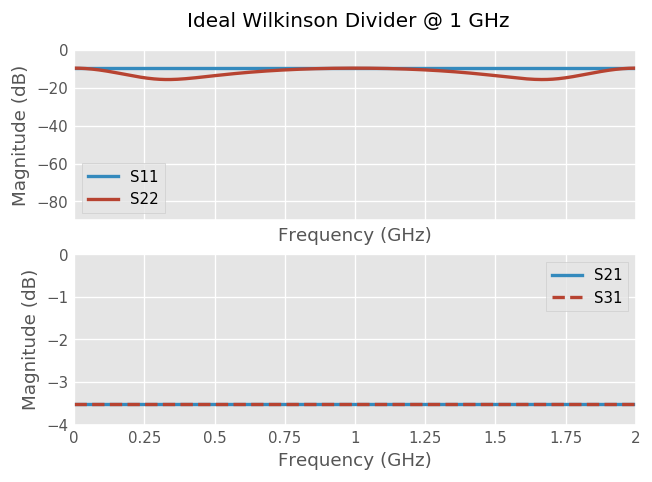

In [11]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
wilkinson.plot_s_db(ax=ax1, m=0, n=0,  lw=2)  # S11
wilkinson.plot_s_db(ax=ax1, m=1, n=1,  lw=2)  # S22
ax1.set_ylim(-90, 0)
wilkinson.plot_s_db(ax=ax2, m=1, n=0,  lw=2)  # S21
wilkinson.plot_s_db(ax=ax2, m=2, n=0,  ls='--', lw=2)  # S31
ax2.set_ylim(-4, 0)
fig.suptitle('Ideal Wilkinson Divider @ 1 GHz')

In [12]:
# the following is failing and I don't know why
np.testing.assert_array_almost_equal(C.network.s_db, wilkinson.s_db)

AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 99.60079840319361%)
 x: array([-9.542425, -3.521825, -3.521825, ..., -3.521825, -3.521825,
       -9.542425])
 y: array([-9.542425, -3.521825, -3.521825, ..., -3.521825, -3.521825,
       -9.542425])